# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

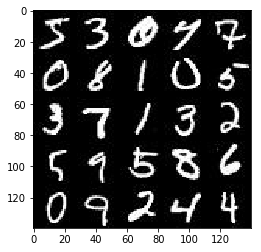

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

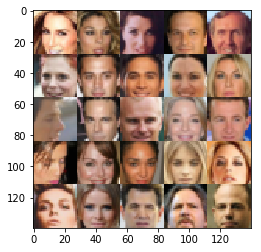

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, shape=(), name="lr")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        
        out = tf.tanh(logits)         

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t = tf.trainable_variables()
    d = [var for var in t if var.name.startswith('discriminator')]
    g = [var for var in t if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './generator.ckpt')
                
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 1.7241
Epoch 1/2... Discriminator Loss: 0.1681... Generator Loss: 2.6896
Epoch 1/2... Discriminator Loss: 1.0241... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 0.7050... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 1.5794... Generator Loss: 2.3272
Epoch 1/2... Discriminator Loss: 0.7083... Generator Loss: 1.4193
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.8040
Epoch 1/2... Discriminator Loss: 0.6409... Generator Loss: 1.4729
Epoch 1/2... Discriminator Loss: 0.5535... Generator Loss: 1.5981
Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 1.7965


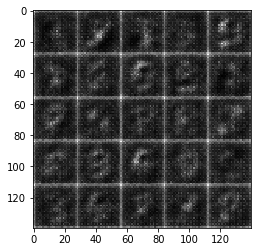

Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.4722
Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 1.4155
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 1.4228
Epoch 1/2... Discriminator Loss: 0.8636... Generator Loss: 1.3825
Epoch 1/2... Discriminator Loss: 0.7241... Generator Loss: 1.0885
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 1.4900
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 1.3073
Epoch 1/2... Discriminator Loss: 0.9768... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.4915


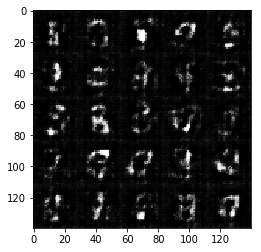

Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 1.6428
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 1.6143
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.0800
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 0.6757... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 1.7419
Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 0.7710... Generator Loss: 1.5232
Epoch 1/2... Discriminator Loss: 0.6701... Generator Loss: 1.1463
Epoch 1/2... Discriminator Loss: 0.5871... Generator Loss: 1.4221


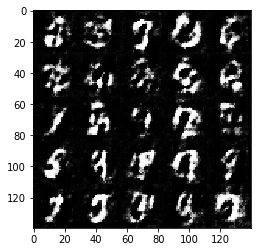

Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.5495
Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 1.5429
Epoch 1/2... Discriminator Loss: 0.6165... Generator Loss: 1.3270
Epoch 1/2... Discriminator Loss: 0.5376... Generator Loss: 1.7951
Epoch 1/2... Discriminator Loss: 0.5381... Generator Loss: 1.6208
Epoch 1/2... Discriminator Loss: 0.6325... Generator Loss: 1.7518
Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 1.7775
Epoch 1/2... Discriminator Loss: 0.4701... Generator Loss: 1.5473
Epoch 1/2... Discriminator Loss: 0.6579... Generator Loss: 1.1372
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 0.9212


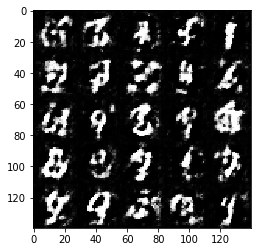

Epoch 1/2... Discriminator Loss: 0.4141... Generator Loss: 1.8911
Epoch 1/2... Discriminator Loss: 0.4523... Generator Loss: 2.2440
Epoch 1/2... Discriminator Loss: 0.4864... Generator Loss: 1.7808
Epoch 1/2... Discriminator Loss: 0.3952... Generator Loss: 1.9454
Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 1.6838
Epoch 1/2... Discriminator Loss: 0.3845... Generator Loss: 1.7110
Epoch 1/2... Discriminator Loss: 0.5094... Generator Loss: 1.3488
Epoch 1/2... Discriminator Loss: 0.4229... Generator Loss: 1.6924
Epoch 1/2... Discriminator Loss: 0.3181... Generator Loss: 2.5582
Epoch 1/2... Discriminator Loss: 0.4498... Generator Loss: 1.5347


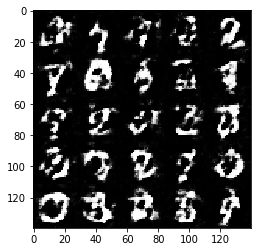

Epoch 1/2... Discriminator Loss: 0.5042... Generator Loss: 1.6914
Epoch 1/2... Discriminator Loss: 0.5991... Generator Loss: 1.0425
Epoch 1/2... Discriminator Loss: 0.3228... Generator Loss: 2.3325
Epoch 1/2... Discriminator Loss: 0.3108... Generator Loss: 2.2451
Epoch 1/2... Discriminator Loss: 0.3675... Generator Loss: 2.7248
Epoch 1/2... Discriminator Loss: 0.5447... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 0.5377... Generator Loss: 1.2267
Epoch 1/2... Discriminator Loss: 0.4921... Generator Loss: 1.4014
Epoch 1/2... Discriminator Loss: 0.4801... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 0.2563... Generator Loss: 2.0361


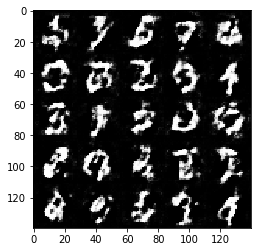

Epoch 1/2... Discriminator Loss: 0.3726... Generator Loss: 2.1699
Epoch 1/2... Discriminator Loss: 0.3573... Generator Loss: 1.9241
Epoch 1/2... Discriminator Loss: 0.6339... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 1.6981
Epoch 1/2... Discriminator Loss: 0.7242... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 1.9541
Epoch 1/2... Discriminator Loss: 0.4108... Generator Loss: 1.8347
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 0.8382... Generator Loss: 3.4207
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 1.9296


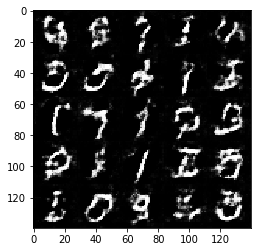

Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 1.0109
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 1.3541
Epoch 1/2... Discriminator Loss: 0.7208... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 0.6535... Generator Loss: 1.1019
Epoch 1/2... Discriminator Loss: 0.5879... Generator Loss: 1.2058
Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 1.7929
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 1.9387... Generator Loss: 0.2767
Epoch 1/2... Discriminator Loss: 0.7524... Generator Loss: 1.1791
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 0.8471


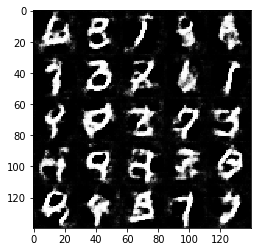

Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 1.5317
Epoch 1/2... Discriminator Loss: 0.5153... Generator Loss: 1.4300
Epoch 1/2... Discriminator Loss: 0.5420... Generator Loss: 1.6509
Epoch 1/2... Discriminator Loss: 0.4825... Generator Loss: 1.7083
Epoch 1/2... Discriminator Loss: 0.6537... Generator Loss: 1.1482
Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 1.4161
Epoch 1/2... Discriminator Loss: 0.7015... Generator Loss: 1.3562
Epoch 1/2... Discriminator Loss: 0.9090... Generator Loss: 1.9448
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 1.5195
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.4851


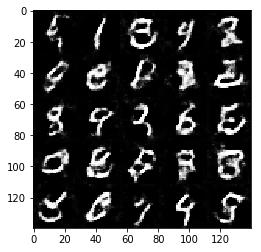

Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.1125
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 1.6893
Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.1503
Epoch 2/2... Discriminator Loss: 0.5291... Generator Loss: 2.0582
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.1081
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.1195
Epoch 2/2... Discriminator Loss: 0.7091... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 2.0984
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 1.0723


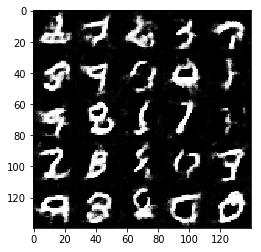

Epoch 2/2... Discriminator Loss: 0.5416... Generator Loss: 1.8844
Epoch 2/2... Discriminator Loss: 0.4204... Generator Loss: 1.8379
Epoch 2/2... Discriminator Loss: 0.5830... Generator Loss: 1.3980
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 1.1998
Epoch 2/2... Discriminator Loss: 0.4688... Generator Loss: 1.9565
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.9373
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.7296
Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 0.9975
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.1628
Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 1.4934


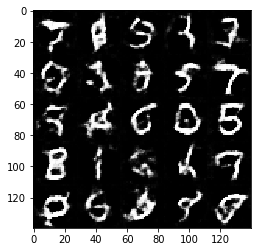

Epoch 2/2... Discriminator Loss: 0.4784... Generator Loss: 2.0905
Epoch 2/2... Discriminator Loss: 0.5881... Generator Loss: 1.8250
Epoch 2/2... Discriminator Loss: 0.5088... Generator Loss: 1.4181
Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 1.1830
Epoch 2/2... Discriminator Loss: 0.6444... Generator Loss: 1.6590
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 1.3446
Epoch 2/2... Discriminator Loss: 1.2045... Generator Loss: 0.4676
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 2.1777
Epoch 2/2... Discriminator Loss: 0.4261... Generator Loss: 1.7998


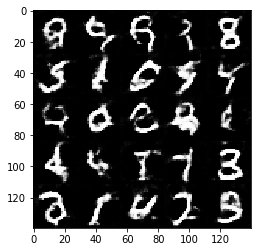

Epoch 2/2... Discriminator Loss: 0.4830... Generator Loss: 1.8765
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.8508
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 0.5762... Generator Loss: 1.5255
Epoch 2/2... Discriminator Loss: 0.7740... Generator Loss: 2.1509
Epoch 2/2... Discriminator Loss: 0.5905... Generator Loss: 1.6630
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 0.9063... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 0.7571... Generator Loss: 2.4751
Epoch 2/2... Discriminator Loss: 0.6165... Generator Loss: 1.2547


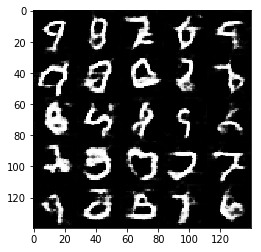

Epoch 2/2... Discriminator Loss: 0.5232... Generator Loss: 1.5402
Epoch 2/2... Discriminator Loss: 0.7326... Generator Loss: 1.2127
Epoch 2/2... Discriminator Loss: 0.5264... Generator Loss: 1.5540
Epoch 2/2... Discriminator Loss: 0.5315... Generator Loss: 1.7916
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 2.2466
Epoch 2/2... Discriminator Loss: 0.5792... Generator Loss: 1.3319
Epoch 2/2... Discriminator Loss: 0.4658... Generator Loss: 1.9254
Epoch 2/2... Discriminator Loss: 0.4597... Generator Loss: 1.6809
Epoch 2/2... Discriminator Loss: 0.6395... Generator Loss: 2.3519
Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 1.4515


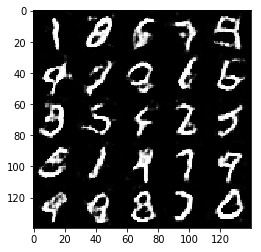

Epoch 2/2... Discriminator Loss: 0.4816... Generator Loss: 1.9945
Epoch 2/2... Discriminator Loss: 0.7258... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 0.6038... Generator Loss: 1.4075
Epoch 2/2... Discriminator Loss: 0.4620... Generator Loss: 1.5722
Epoch 2/2... Discriminator Loss: 0.5524... Generator Loss: 1.3929
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 2.0456
Epoch 2/2... Discriminator Loss: 0.5467... Generator Loss: 1.3727
Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 1.7008
Epoch 2/2... Discriminator Loss: 0.5218... Generator Loss: 1.5517
Epoch 2/2... Discriminator Loss: 0.5041... Generator Loss: 1.4076


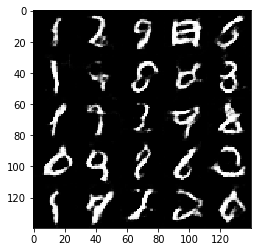

Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 1.4817
Epoch 2/2... Discriminator Loss: 0.3601... Generator Loss: 1.7275
Epoch 2/2... Discriminator Loss: 0.4218... Generator Loss: 1.8877
Epoch 2/2... Discriminator Loss: 0.4851... Generator Loss: 1.3473
Epoch 2/2... Discriminator Loss: 0.4058... Generator Loss: 1.8112
Epoch 2/2... Discriminator Loss: 0.5122... Generator Loss: 1.6278
Epoch 2/2... Discriminator Loss: 0.5162... Generator Loss: 1.5927
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 0.4403... Generator Loss: 1.5998


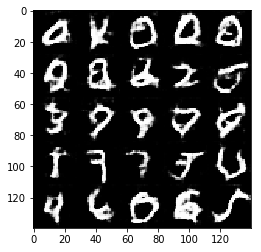

Epoch 2/2... Discriminator Loss: 0.5822... Generator Loss: 1.3234
Epoch 2/2... Discriminator Loss: 0.6156... Generator Loss: 1.1024
Epoch 2/2... Discriminator Loss: 0.5540... Generator Loss: 1.4804
Epoch 2/2... Discriminator Loss: 0.4488... Generator Loss: 1.9337
Epoch 2/2... Discriminator Loss: 0.4262... Generator Loss: 1.5058
Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 1.7388
Epoch 2/2... Discriminator Loss: 0.3870... Generator Loss: 1.9855
Epoch 2/2... Discriminator Loss: 0.4128... Generator Loss: 1.8590
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 2.0295
Epoch 2/2... Discriminator Loss: 0.5827... Generator Loss: 1.1613


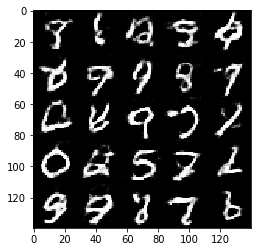

Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 1.8810
Epoch 2/2... Discriminator Loss: 0.5731... Generator Loss: 1.1792
Epoch 2/2... Discriminator Loss: 1.7656... Generator Loss: 0.2752
Epoch 2/2... Discriminator Loss: 0.4921... Generator Loss: 1.9512
Epoch 2/2... Discriminator Loss: 0.5191... Generator Loss: 1.2894
Epoch 2/2... Discriminator Loss: 0.4744... Generator Loss: 1.4990
Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 0.9055
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 1.8066
Epoch 2/2... Discriminator Loss: 0.3000... Generator Loss: 1.8091
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 0.7790


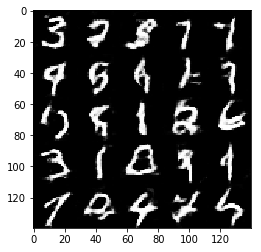

Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 1.5766
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 0.6450... Generator Loss: 1.0995
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 1.3599
Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 2.3845
Epoch 2/2... Discriminator Loss: 0.5578... Generator Loss: 1.2464
Epoch 2/2... Discriminator Loss: 0.4401... Generator Loss: 1.4709


In [18]:
batch_size = 64
z_dim = 120
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3172... Generator Loss: 2.2762
Epoch 1/1... Discriminator Loss: 0.1166... Generator Loss: 2.9933
Epoch 1/1... Discriminator Loss: 0.2990... Generator Loss: 2.0916
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 3.1205
Epoch 1/1... Discriminator Loss: 0.2510... Generator Loss: 3.5582
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 1.7974
Epoch 1/1... Discriminator Loss: 0.0734... Generator Loss: 6.1932
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 2.1249
Epoch 1/1... Discriminator Loss: 0.4462... Generator Loss: 1.7980
Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 2.1732


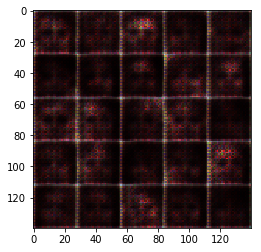

Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 1.8083
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 5.6321
Epoch 1/1... Discriminator Loss: 0.2989... Generator Loss: 2.9830
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.5614
Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 2.0246
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 3.7052
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 3.5421
Epoch 1/1... Discriminator Loss: 0.5567... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.4003


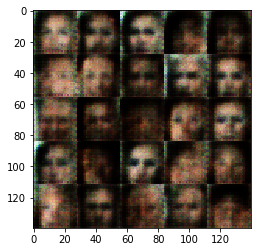

Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.3721
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 3.0638
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 1.7946
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 2.4395


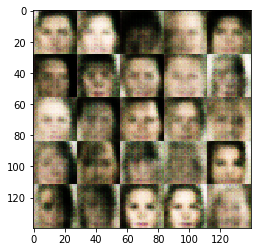

Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.0893
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.9908
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.0890
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 1.8197
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.2067


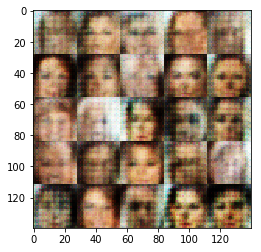

Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 2.5345
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.3436
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 2.2043
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.2049
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 1.8283
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.2789


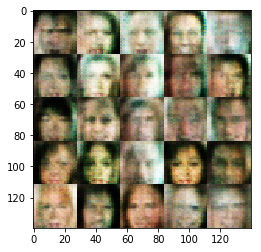

Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.7864... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 1.5792


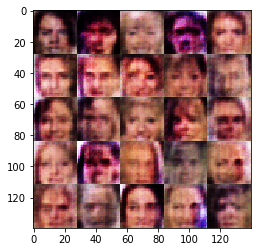

Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.3127
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.3692
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.2122


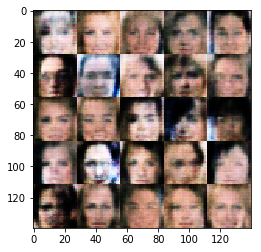

Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.1647
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.1387
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.7594
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 0.9632


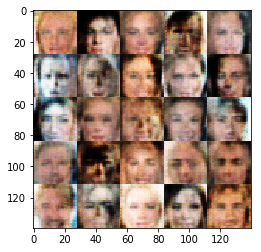

Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.4609
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.4193
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 0.9109


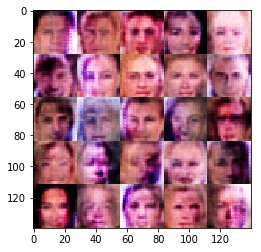

Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.5634
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.2435


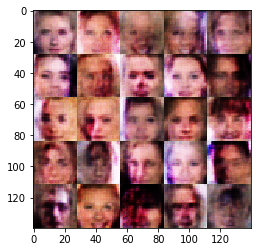

Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.4770
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.3119
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.7297
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.2633
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.8977


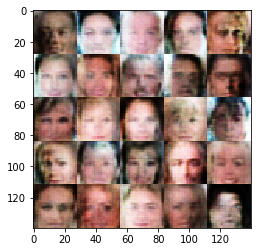

Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.7437
Epoch 1/1... Discriminator Loss: 0.8359... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 1.6400
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 1.9614


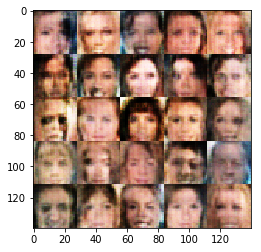

Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 1.1880
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 1.9048


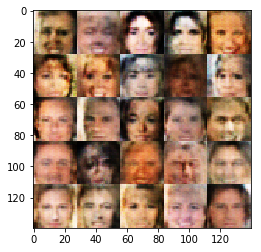

Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.1843
Epoch 1/1... Discriminator Loss: 0.6693... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.1204
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.7991


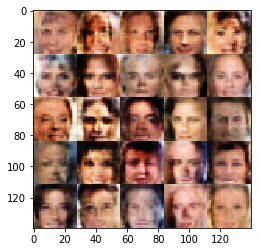

Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.2633
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.4414
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.8349


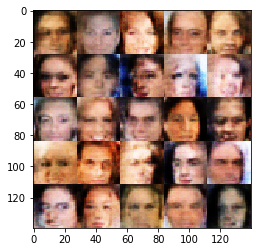

Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.6338
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.4220
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 1.5097
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 2.1567
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.2804


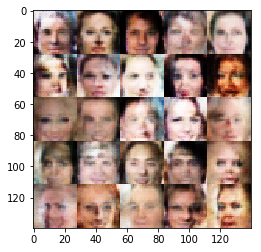

Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.5723
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 1.8064


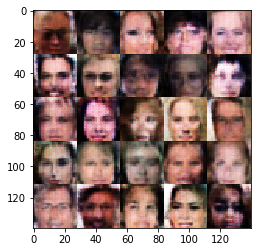

Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.8648
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 2.2253
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.5064
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 2.1874
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 1.7147
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.8024
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 0.9221


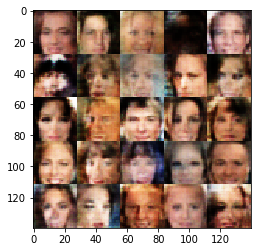

Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 3.1951
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 2.1436
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 4.7793
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.6575


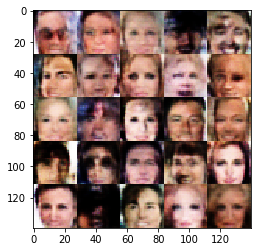

Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 2.4689
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 3.4804
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.0329
Epoch 1/1... Discriminator Loss: 0.4765... Generator Loss: 1.4809
Epoch 1/1... Discriminator Loss: 0.1921... Generator Loss: 2.8869
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 0.2443... Generator Loss: 2.0701
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.9861... Generator Loss: 0.2181


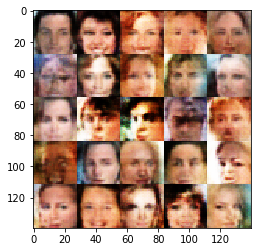

Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 0.2448... Generator Loss: 3.1724
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 3.8309
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 1.8891
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 1.4627
Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 2.8241
Epoch 1/1... Discriminator Loss: 2.6229... Generator Loss: 0.1046
Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.3448
Epoch 1/1... Discriminator Loss: 0.1940... Generator Loss: 3.7351


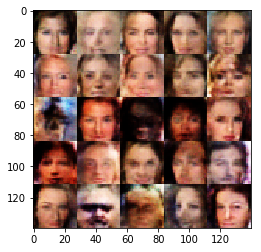

Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 3.0003
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.5062
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 2.7951
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 2.1065
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 3.1936
Epoch 1/1... Discriminator Loss: 0.7940... Generator Loss: 3.2075
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.5640


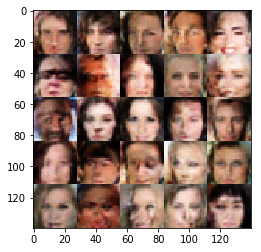

Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.5087... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.6063
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.3719
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 3.0261
Epoch 1/1... Discriminator Loss: 1.6695... Generator Loss: 0.2975
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 2.5766
Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 1.1215
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 2.0127


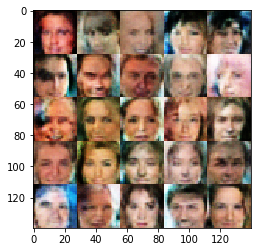

Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 2.0465
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 0.3142... Generator Loss: 2.1094
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.9109
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.3021
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 2.3587


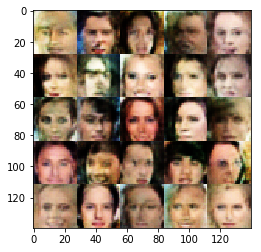

Epoch 1/1... Discriminator Loss: 0.1960... Generator Loss: 2.9622
Epoch 1/1... Discriminator Loss: 0.1493... Generator Loss: 3.3080
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 1.7966
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 3.6301
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 0.6330... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 3.3156
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 1.4572
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 1.0685


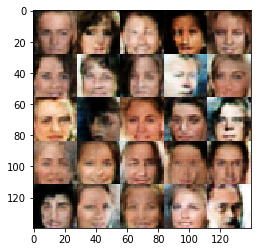

Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 1.7984
Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 2.1076
Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 1.3723
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 0.3179... Generator Loss: 3.0034
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 0.2285... Generator Loss: 2.0264
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 2.1385


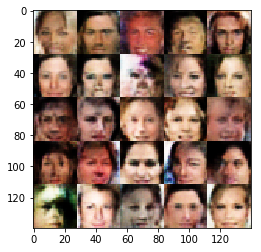

Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 2.1719
Epoch 1/1... Discriminator Loss: 0.2223... Generator Loss: 4.1408
Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 1.6627
Epoch 1/1... Discriminator Loss: 0.2793... Generator Loss: 2.8557
Epoch 1/1... Discriminator Loss: 0.2176... Generator Loss: 2.5493
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 3.4960
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 4.8237
Epoch 1/1... Discriminator Loss: 0.3130... Generator Loss: 3.3877
Epoch 1/1... Discriminator Loss: 0.1837... Generator Loss: 5.0718


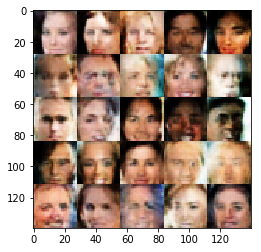

Epoch 1/1... Discriminator Loss: 0.2924... Generator Loss: 1.8556
Epoch 1/1... Discriminator Loss: 0.2292... Generator Loss: 1.9749
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.2362... Generator Loss: 2.1897
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 0.2195... Generator Loss: 2.8353
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.3250
Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 3.1392
Epoch 1/1... Discriminator Loss: 0.2070... Generator Loss: 2.2864
Epoch 1/1... Discriminator Loss: 0.0689... Generator Loss: 4.0676


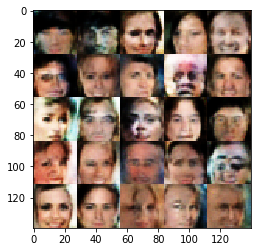

Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 1.4532
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 0.1346... Generator Loss: 4.4214
Epoch 1/1... Discriminator Loss: 0.1237... Generator Loss: 3.5852
Epoch 1/1... Discriminator Loss: 0.1062... Generator Loss: 3.4082
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 0.0889... Generator Loss: 3.9161
Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 0.9312


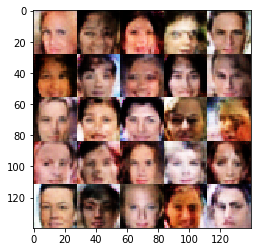

Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 1.1596
Epoch 1/1... Discriminator Loss: 0.2350... Generator Loss: 2.0632
Epoch 1/1... Discriminator Loss: 0.2262... Generator Loss: 2.1612
Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 0.1360... Generator Loss: 4.6510
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 5.0775
Epoch 1/1... Discriminator Loss: 0.0632... Generator Loss: 4.7725
Epoch 1/1... Discriminator Loss: 0.1027... Generator Loss: 5.4586
Epoch 1/1... Discriminator Loss: 0.1048... Generator Loss: 3.2652


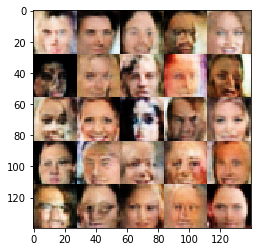

Epoch 1/1... Discriminator Loss: 0.1895... Generator Loss: 2.5111
Epoch 1/1... Discriminator Loss: 0.2761... Generator Loss: 2.2293
Epoch 1/1... Discriminator Loss: 0.2068... Generator Loss: 2.2890
Epoch 1/1... Discriminator Loss: 0.3208... Generator Loss: 1.7670
Epoch 1/1... Discriminator Loss: 0.1180... Generator Loss: 2.5995
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 2.2024... Generator Loss: 0.1782
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.9968
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.1988... Generator Loss: 3.3449


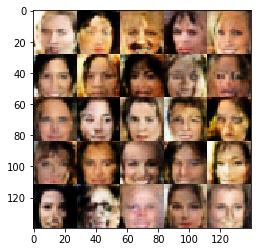

Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 1.4138
Epoch 1/1... Discriminator Loss: 0.1391... Generator Loss: 3.9232
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 3.5120
Epoch 1/1... Discriminator Loss: 0.3099... Generator Loss: 1.7254
Epoch 1/1... Discriminator Loss: 0.1521... Generator Loss: 3.2380
Epoch 1/1... Discriminator Loss: 0.1767... Generator Loss: 2.5373


In [19]:
batch_size = 64
z_dim = 120
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.